![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 9.3 Regularized Multinomial Logistic Regression

This tutorial will guide you through performing regularized multinomial logistic regression in Python. We'll cover both a manual approach—building the model from scratch—and using the popular `scikit-learn` library, which offers efficient algorithms for solving penalized regression problems. By the end of this tutorial, you will thoroughly understand how to fit regularized multinomial logistic regression models in Python, both by manually implementing the model and utilizing efficient libraries for regularized model fitting. Mastering regularized multinomial logistic regression is an essential skill for any data scientist or statistician, whether you are working with high-dimensional data or aiming to improve the interpretability of your models.

## Overview

Multinomial Logistic Regression (MLR) is an extension of binary logistic regression used when the dependent variable $y$ is categorical with more than two levels (e.g., $C$ classes, $y \in \{1, 2, \dots, C\}$). Regularization is added to the optimization process to prevent overfitting by penalizing large coefficients.

The common regularization techniques are:

***Ridge Regularization (L2)***

Adds a penalty proportional to the square of the coefficients:
$$
\mathcal{R}_{\text{ridge}} = \lambda \sum_{c=1}^C \|\mathbf{\beta}_c\|_2^2
$$
where $\lambda > 0$ is the regularization strength. The objective becomes:
$$ \ell_{\text{ridge}}(\beta) = \ell(\beta) - \lambda \sum_{c=1}^C \|\mathbf{\beta}_c\|_2^2 $$

***Lasso Regularization (L1)***

Adds a penalty proportional to the absolute value of the coefficients:
$$
\mathcal{R}_{\text{lasso}} = \lambda \sum_{c=1}^C \|\mathbf{\beta}_c\|_1
$$
The objective becomes:
$$
\ell_{\text{lasso}}(\beta) = \ell(\beta) - \lambda \sum_{c=1}^C \|\mathbf{\beta}_c\|_1
$$

***Elastic Net Regularization***

Combines L1 and L2 penalties:
$$
\mathcal{R}_{\text{elastic}} = \lambda \left[ (1-\alpha) \sum_{c=1}^C \|\mathbf{\beta}_c\|_2^2 + \alpha \sum_{c=1}^C \|\mathbf{\beta}_c\|_1 \right]
$$
The objective becomes:
$$
\ell_{\text{elastic}}(\beta) = \ell(\beta) - \lambda \left[ (1-\alpha) \sum_{c=1}^C \|\mathbf{\beta}_c\|_2^2 + \alpha \sum_{c=1}^C \|\mathbf{\beta}_c\|_1 \right]
$$

In the Optimization Process, the parameters are estimated by solving:
$$
\arg \max_{\beta} \ell(\beta) - \mathcal{R}(\beta)
$$
where $\mathcal{R}(\beta)$ is the chosen regularization term.

Compute probabilities using the softmax function. Assign class $c$ with the highest probability:
$$
\hat{y} = \arg \max_{c} P(y = c \mid \mathbf{x})
$$

Use metrics like accuracy, cross-entropy loss, or confusion matrix to evaluate performance.

## Setup and Installation

First, let's install and import the necessary Python packages.

In [1]:
# Install required packages (uncomment if needed)
# !pip install numpy pandas scikit-learn matplotlib seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)

## Regularized Multinomial Logistic Regression from Scratch

Fitting a regularized multinomial logistic regression in Python without using external machine learning libraries can be achieved by manually implementing the necessary steps. Here's a comprehensive guide to perform this task:

### Synthetic Data Generation

We will generate a synthetic dataset with three classes and multiple predictors.

In [2]:
# 1. Generate synthetic data
n = 300 # Number of observations
p = 10 # Number of predictors
k = 3 # Number of classes
# Generate predictors
X = np.random.randn(n, p)
# Generate coefficients
beta = np.random.randn(p, k - 1)
# Compute linear predictors and probabilities
eta = np.column_stack([np.zeros(n), X @ beta]) # Linear predictors for k-1 classes
prob = np.exp(eta) / np.sum(np.exp(eta), axis=1, keepdims=True) # Convert to probabilities
# Generate multinomial response
y = np.array([np.random.choice(k, p=prob[i]) for i in range(n)])
# Convert to DataFrame for easier handling
data = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(p)])
data['y'] = y
print(data.head())

         X1        X2        X3        X4        X5        X6        X7  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1 -0.463418 -0.465730  0.241962 -1.913280 -1.724918 -0.562288 -1.012831   
2  1.465649 -0.225776  0.067528 -1.424748 -0.544383  0.110923 -1.150994   
3 -0.601707  1.852278 -0.013497 -1.057711  0.822545 -1.220844  0.208864   
4  0.738467  0.171368 -0.115648 -0.301104 -1.478522 -0.719844 -0.460639   

         X8        X9       X10  y  
0  0.767435 -0.469474  0.542560  0  
1  0.314247 -0.908024 -1.412304  2  
2  0.375698 -0.600639 -0.291694  2  
3 -1.959670 -1.328186  0.196861  2  
4  1.057122  0.343618 -1.763040  0  


### Cross-validation setup and Regularization

Create a 5-fold cross-validation setup and define the hyperparameters for regularization.

In [3]:
# 2. Cross-validation setup
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = np.zeros(n, dtype=int)
for i, (_, test_idx) in enumerate(kf.split(X)):
    folds[test_idx] = i
# Define hyperparameters
alphas = np.arange(0, 1.1, 0.1) # Elastic net mixing parameter
lambdas = np.logspace(-4, 1, 10) # Regularization strengths

### Create Loss Functions and Optimization

Define the loss functions for Ridge, Lasso, and Elastic Net regularization. The loss functions compute the negative log-likelihood of the multinomial logistic regression model with the penalty term.

In [4]:
# 3. Loss functions for regularized multinomial logistic regression
def ridge_loss(beta_vec, X, y, lambda_reg, k):
    n, p = X.shape
    beta = beta_vec.reshape(p, k - 1)
    
    # Compute linear predictors and probabilities
    eta = np.column_stack([np.zeros(n), X @ beta])
    prob = np.exp(eta) / np.sum(np.exp(eta), axis=1, keepdims=True)
    
    # Multinomial negative log-likelihood
    log_lik = -np.sum(np.log(prob[np.arange(n), y]))
    
    # Ridge penalty
    ridge_penalty = lambda_reg * np.sum(beta**2)
    
    return log_lik + ridge_penalty

def lasso_loss(beta_vec, X, y, lambda_reg, k):
    n, p = X.shape
    beta = beta_vec.reshape(p, k - 1)
    
    # Compute linear predictors and probabilities
    eta = np.column_stack([np.zeros(n), X @ beta])
    prob = np.exp(eta) / np.sum(np.exp(eta), axis=1, keepdims=True)
    
    # Multinomial negative log-likelihood
    log_lik = -np.sum(np.log(prob[np.arange(n), y]))
    
    # Lasso penalty
    lasso_penalty = lambda_reg * np.sum(np.abs(beta))
    
    return log_lik + lasso_penalty

def elastic_net_loss(beta_vec, X, y, lambda_reg, alpha, k):
    n, p = X.shape
    beta = beta_vec.reshape(p, k - 1)
    
    # Compute linear predictors and probabilities
    eta = np.column_stack([np.zeros(n), X @ beta])
    prob = np.exp(eta) / np.sum(np.exp(eta), axis=1, keepdims=True)
    
    # Multinomial negative log-likelihood
    log_lik = -np.sum(np.log(prob[np.arange(n), y]))
    
    # Elastic net penalty
    ridge_penalty = (1 - alpha) * lambda_reg * np.sum(beta**2)
    lasso_penalty = alpha * lambda_reg * np.sum(np.abs(beta))
    
    return log_lik + ridge_penalty + lasso_penalty

# Optimization function
def optimize_model(X, y, lambda_reg, alpha=None, k=3, loss_function=None):
    n, p = X.shape
    beta_init = np.random.randn(p * (k - 1))
    
    if loss_function is None:
        raise ValueError("Loss function must be specified")
    
    # Define the objective function for optimization
    if alpha is None: # For Ridge or Lasso
        result = minimize(loss_function, beta_init, args=(X, y, lambda_reg, k),
                         method='L-BFGS-B', options={'maxiter': 1000})
    else: # For Elastic Net
        def objective(beta_vec):
            return loss_function(beta_vec, X, y, lambda_reg, alpha, k)
        result = minimize(objective, beta_init, method='L-BFGS-B', options={'maxiter': 1000})
    
    if not result.success:
        print(f"Optimization warning: {result.message}")
    
    return result.x.reshape(p, k - 1)

### Hyperparameter Selection via Cross-Validation

Perform hyperparameter selection via cross-validation to find the best model and hyperparameters.

In [5]:
# 4. Hyperparameter selection via Cross-Validation
cv_results = []
# Define models
models = ["Ridge", "Lasso", "ElasticNet"]
for model in models:
    for alpha in alphas:
        for lambda_reg in lambdas:
            log_losses = []
            for fold in range(5):
                train_idx = np.where(folds != fold)[0]
                test_idx = np.where(folds == fold)[0]
                
                # Train model
                if model == "Ridge":
                    beta = optimize_model(X[train_idx], y[train_idx], lambda_reg,
                                        alpha=None, k=k, loss_function=ridge_loss)
                elif model == "Lasso":
                    beta = optimize_model(X[train_idx], y[train_idx], lambda_reg,
                                        alpha=None, k=k, loss_function=lasso_loss)
                elif model == "ElasticNet":
                    beta = optimize_model(X[train_idx], y[train_idx], lambda_reg,
                                        alpha=alpha, k=k, loss_function=elastic_net_loss)
                
                # Predict on test data
                eta_test = np.column_stack([np.zeros(len(test_idx)), X[test_idx] @ beta])
                prob_test = np.exp(eta_test) / np.sum(np.exp(eta_test), axis=1, keepdims=True)
                
                # Compute log-loss
                log_loss_val = -np.mean(np.log(prob_test[np.arange(len(test_idx)), y[test_idx]]))
                log_losses.append(log_loss_val)
            
            cv_results.append({
                'Model': model,
                'alpha': alpha,
                'lambda': lambda_reg,
                'log_loss': np.mean(log_losses)
            })
# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)
# Best model and hyperparameters
best_params = cv_results_df.loc[cv_results_df['log_loss'].idxmin()]
best_model = best_params['Model']
best_alpha = best_params['alpha']
best_lambda = best_params['lambda']
print(f"Best Model: {best_model}")
print(f"Best Alpha: {best_alpha}")
print(f"Best Lambda: {best_lambda}")
print(f"Best Log Loss: {best_params['log_loss']:.4f}")

Optimization warning: ABNORMAL: 
Optimization warning: ABNORMAL: 
Best Model: Ridge
Best Alpha: 0.8
Best Lambda: 0.21544346900318845
Best Log Loss: 0.5195


### Fit ridge, lasso, and elastic net models

Fit the final models using the best hyperparameters obtained from cross-validation.

In [6]:
# Fit final models
ridge_beta = optimize_model(X, y, best_lambda, alpha=None, k=k, loss_function=ridge_loss)
lasso_beta = optimize_model(X, y, best_lambda, alpha=None, k=k, loss_function=lasso_loss)
elastic_net_beta = optimize_model(X, y, best_lambda, alpha=best_alpha, k=k, loss_function=elastic_net_loss)
print("Models fitted successfully!")

Models fitted successfully!


### Model Evaluation

Best Model: Ridge
Confusion Matrix:
[[ 74   6  12]
 [ 11  71   7]
 [ 11   8 100]]
Overall Accuracy: 0.8167
In-Class Accuracy: [0.80434783 0.79775281 0.84033613]
Cross-Entropy: 0.4634


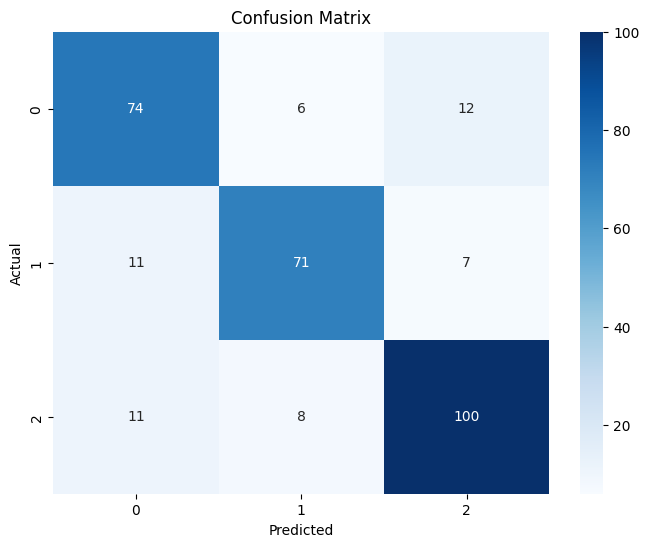

In [7]:
# Model Evaluation for Elastic Net (you can do the same for Ridge and Lasso)
eta = np.column_stack([np.zeros(n), X @ elastic_net_beta])
prob = np.exp(eta) / np.sum(np.exp(eta), axis=1, keepdims=True)
predictions = np.argmax(prob, axis=1)
# Confusion matrix
conf_mat = confusion_matrix(y, predictions)
# Overall accuracy
accuracy = accuracy_score(y, predictions)
# In-class accuracy (precision for each class)
in_class_acc = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
# Cross-entropy
cross_entropy = log_loss(y, prob)
# Output results
print(f"Best Model: {best_model}")
print(f"Confusion Matrix:\n{conf_mat}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"In-Class Accuracy: {in_class_acc}")
print(f"Cross-Entropy: {cross_entropy:.4f}")
# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(k), yticklabels=range(k))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Regularized Multinomial Logistic Regression using scikit-learn

In Python, you can perform multinomial logistic regression using the `scikit-learn` library, which provides the `LogisticRegression` class that supports various types of regularization including L1 (Lasso), L2 (Ridge), and Elastic Net for multinomial logistic regression.

### Load and Prepare Data

Let's use a real dataset for this part of the tutorial. We'll use the health insurance dataset as mentioned in the R tutorial.

In [10]:
# Load the health insurance data
url = "hhttps://raw.githubusercontent.com/zia207/Data/main/CSV_files/health_insurance.csv"
try:
    df = pd.read_csv(url)
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")
    # Create sample data if URL fails
    np.random.seed(42)
    n_samples = 1000
    df = pd.DataFrame({
        'age': np.random.randint(20, 65, n_samples),
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'household': np.random.randint(1, 6, n_samples),
        'position_level': np.random.randint(1, 6, n_samples),
        'absent': np.random.randint(0, 20, n_samples),
        'product': np.random.choice(['A', 'B', 'C'], n_samples, p=[0.5, 0.3, 0.2])
    })
    print("Using sample data instead.")
# Display basic info
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nProduct distribution:")
print(df['product'].value_counts())

Error loading data: Protocol not known: hhttps
Using sample data instead.
   age  gender  household  position_level  absent product
0   58    Male          5               2      19       C
1   48  Female          3               5      17       A
2   34  Female          1               1      11       A
3   62  Female          1               3       8       A
4   27  Female          4               3       4       A

Dataset shape: (1000, 6)

Product distribution:
product
A    503
B    302
C    195
Name: count, dtype: int64


### Data Preprocessing

In [11]:
# Convert categorical variables to appropriate types
df['product'] = df['product'].astype('category')
df['gender'] = df['gender'].astype('category')
# Create feature matrix and target vector
X = df.drop('product', axis=1)
y = df['product']
# Create dummy variables for categorical features
X = pd.get_dummies(X, drop_first=True)
print(f"Feature matrix shape: {X.shape}")
print(f"Features: {list(X.columns)}")

Feature matrix shape: (1000, 5)
Features: ['age', 'household', 'position_level', 'absent', 'gender_Male']


### Split Data into Training and Test Sets

In [12]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set product distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest set product distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 700
Test set size: 300

Training set product distribution:
product
A    0.502857
B    0.301429
C    0.195714
Name: proportion, dtype: float64

Test set product distribution:
product
A    0.503333
B    0.303333
C    0.193333
Name: proportion, dtype: float64


### Ridge Regression (L2 Regularization)

#### Cross-validation for the best lambda (C parameter)

In scikit-learn, the regularization strength is controlled by the `C` parameter (inverse of lambda). Smaller values of C correspond to stronger regularization.

/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/s

Best parameters for Ridge: {'C': np.float64(0.0001)}
Best cross-validation score: 1.0287


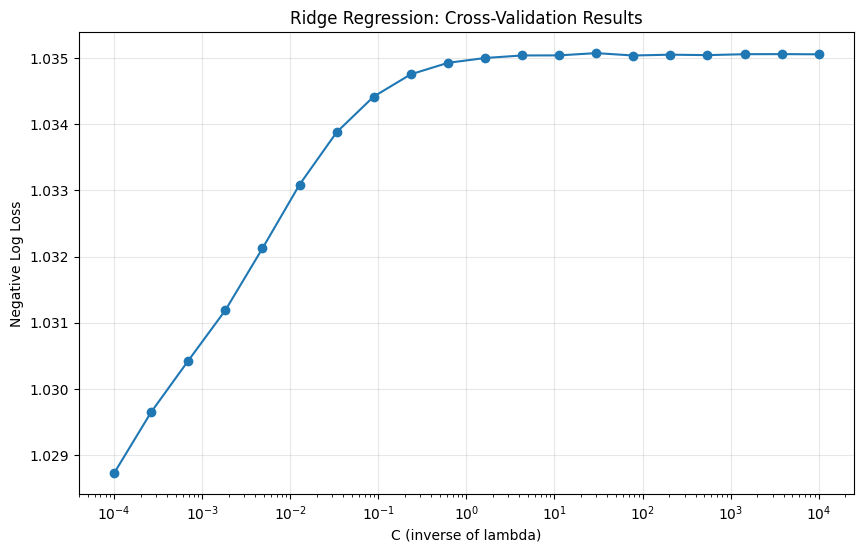

In [13]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Define parameter grid for Ridge (L2) regression
param_grid_ridge = {'C': np.logspace(-4, 4, 20)}
# Create Ridge (L2) logistic regression model
ridge_model = LogisticRegression(
    penalty='l2', # L2 regularization (Ridge)
    multi_class='multinomial', # Multinomial logistic regression
    solver='lbfgs', # Solver that supports multinomial logistic regression
    max_iter=1000,
    random_state=42
)
# Perform grid search with cross-validation
ridge_grid = GridSearchCV(
    ridge_model,
    param_grid_ridge,
    cv=cv,
    scoring='neg_log_loss', # Use negative log loss for evaluation
    n_jobs=-1
)
# Fit the grid search
ridge_grid.fit(X_train, y_train)
# Best parameters
print(f"Best parameters for Ridge: {ridge_grid.best_params_}")
print(f"Best cross-validation score: {-ridge_grid.best_score_:.4f}")
# Plot cross-validation results
plt.figure(figsize=(10, 6))
results = pd.DataFrame(ridge_grid.cv_results_)
plt.semilogx(results['param_C'], -results['mean_test_score'], marker='o')
plt.xlabel('C (inverse of lambda)')
plt.ylabel('Negative Log Loss')
plt.title('Ridge Regression: Cross-Validation Results')
plt.grid(True, alpha=0.3)
plt.show()

#### Fit Ridge Regression

Ridge Regression Coefficients:
      age  household  position_level  absent  gender_Male
A -0.0028     0.0022         -0.0004  0.0011       0.0008
B  0.0026     0.0000          0.0003 -0.0026      -0.0003
C  0.0002    -0.0022          0.0001  0.0015      -0.0005


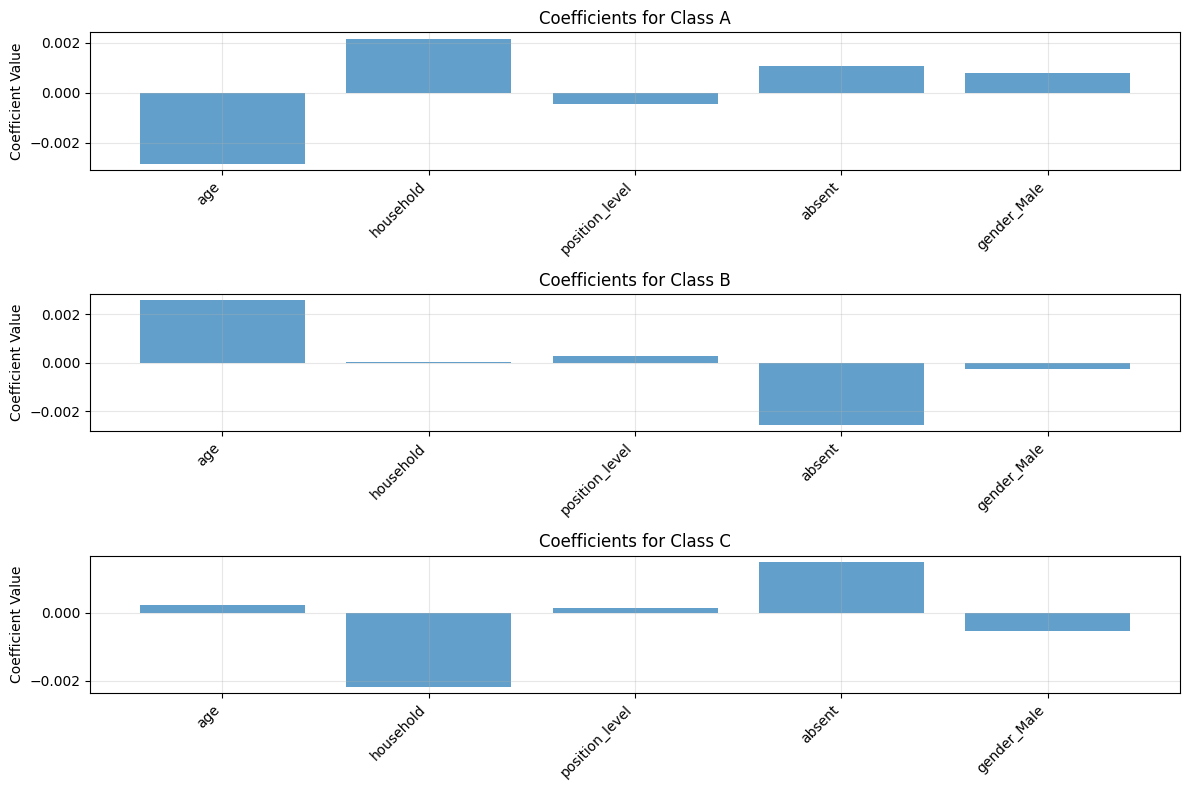

In [14]:
# Fit the final Ridge model with the best parameters
best_C_ridge = ridge_grid.best_params_['C']
ridge_final = LogisticRegression(
    penalty='l2',
    C=best_C_ridge,
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
ridge_final.fit(X_train, y_train)
# Display regression coefficients
coef_df = pd.DataFrame(
    ridge_final.coef_,
    columns=X.columns,
    index=ridge_final.classes_
)
print("Ridge Regression Coefficients:")
print(coef_df.round(4))
# Plot coefficients
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(ridge_final.classes_):
    plt.subplot(len(ridge_final.classes_), 1, i+1)
    plt.bar(range(len(X.columns)), ridge_final.coef_[i], alpha=0.7)
    plt.title(f'Coefficients for Class {class_name}')
    plt.xticks(range(len(X.columns)), X.columns, rotation=45, ha='right')
    plt.ylabel('Coefficient Value')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Prediction on Test Data

Ridge Regression Results:
Accuracy: 0.5033
Error Rate: 0.4967
Log Loss: 1.0260

Confusion Matrix:
[[151   0   0]
 [ 91   0   0]
 [ 58   0   0]]


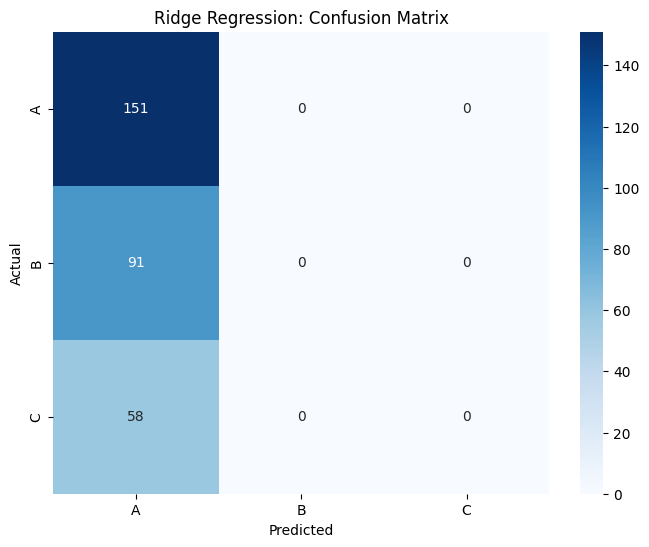


Classification Report:
              precision    recall  f1-score   support

           A       0.50      1.00      0.67       151
           B       0.00      0.00      0.00        91
           C       0.00      0.00      0.00        58

    accuracy                           0.50       300
   macro avg       0.17      0.33      0.22       300
weighted avg       0.25      0.50      0.34       300



In [15]:
# Make predictions on the test data
y_pred_ridge = ridge_final.predict(X_test)
y_pred_proba_ridge = ridge_final.predict_proba(X_test)
# Calculate metrics
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
log_loss_ridge = log_loss(y_test, y_pred_proba_ridge)
print(f"Ridge Regression Results:")
print(f"Accuracy: {accuracy_ridge:.4f}")
print(f"Error Rate: {1 - accuracy_ridge:.4f}")
print(f"Log Loss: {log_loss_ridge:.4f}")
# Confusion matrix
cm_ridge = confusion_matrix(y_test, y_pred_ridge)
print(f"\nConfusion Matrix:")
print(cm_ridge)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Blues',
            xticklabels=ridge_final.classes_,
            yticklabels=ridge_final.classes_)
plt.title('Ridge Regression: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ridge))

### Lasso Regression (L1 Regularization)

#### Cross-validation for the best lambda (C parameter)

/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/s

Best parameters for Lasso: {'C': np.float64(0.004832930238571752)}
Best cross-validation score: 1.0266


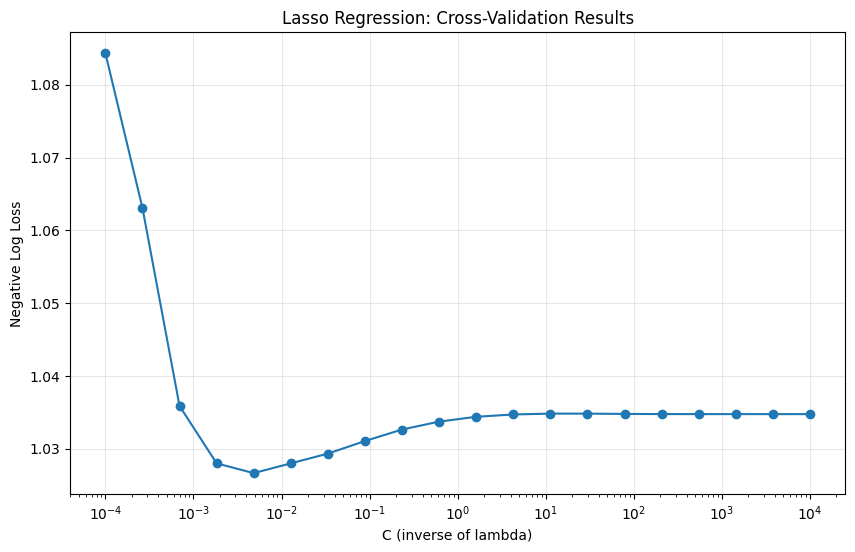

In [16]:
# Define parameter grid for Lasso (L1) regression
param_grid_lasso = {'C': np.logspace(-4, 4, 20)}
# Create Lasso (L1) logistic regression model
# Note: For L1 regularization with multinomial, we need to use solver='saga'
lasso_model = LogisticRegression(
    penalty='l1', # L1 regularization (Lasso)
    multi_class='multinomial',
    solver='saga', # Solver that supports L1 penalty with multinomial
    max_iter=1000,
    random_state=42
)
# Perform grid search with cross-validation
lasso_grid = GridSearchCV(
    lasso_model,
    param_grid_lasso,
    cv=cv,
    scoring='neg_log_loss',
    n_jobs=-1
)
# Fit the grid search
lasso_grid.fit(X_train, y_train)
# Best parameters
print(f"Best parameters for Lasso: {lasso_grid.best_params_}")
print(f"Best cross-validation score: {-lasso_grid.best_score_:.4f}")
# Plot cross-validation results
plt.figure(figsize=(10, 6))
results_lasso = pd.DataFrame(lasso_grid.cv_results_)
plt.semilogx(results_lasso['param_C'], -results_lasso['mean_test_score'], marker='o')
plt.xlabel('C (inverse of lambda)')
plt.ylabel('Negative Log Loss')
plt.title('Lasso Regression: Cross-Validation Results')
plt.grid(True, alpha=0.3)
plt.show()

#### Fit Lasso Regression

Lasso Regression Coefficients:
   age  household  position_level  absent  gender_Male
A  0.0        0.0             0.0     0.0          0.0
B  0.0        0.0             0.0     0.0          0.0
C  0.0        0.0             0.0     0.0          0.0

Non-zero coefficients: 0 out of 15
Sparsity: 100.00%


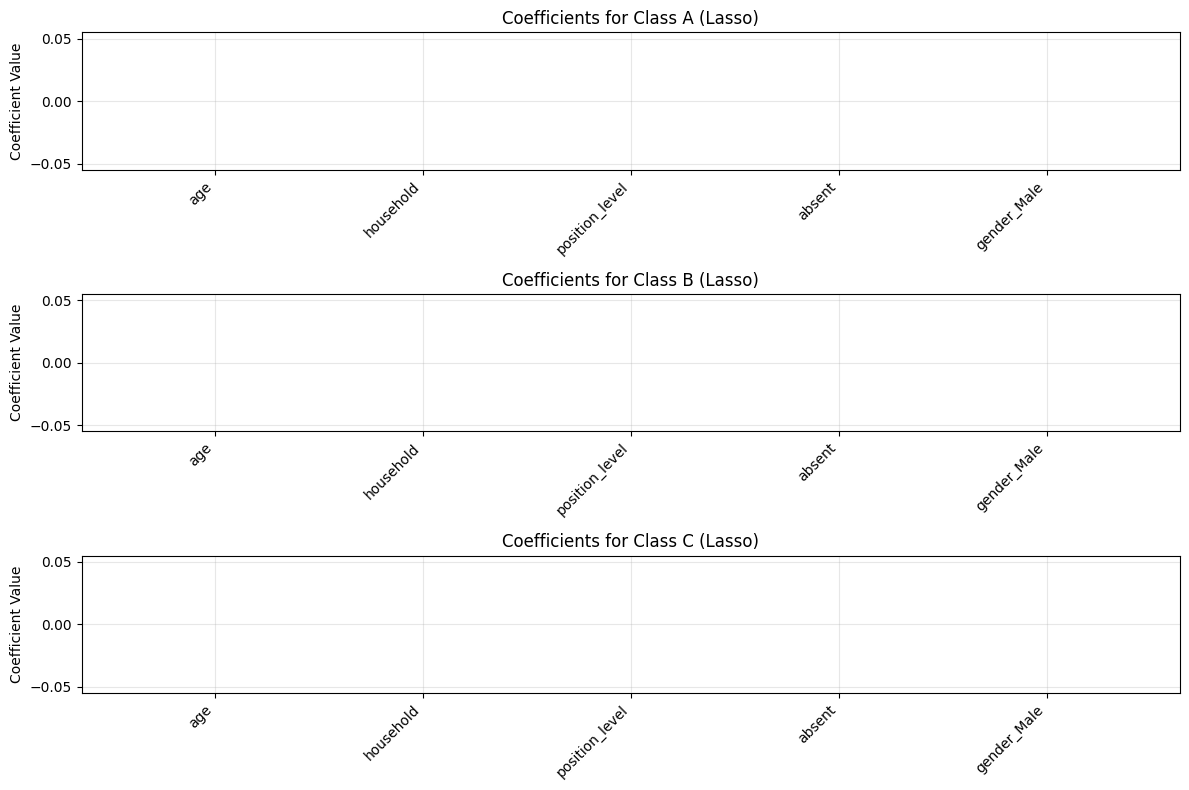

In [17]:
# Fit the final Lasso model with the best parameters
best_C_lasso = lasso_grid.best_params_['C']
lasso_final = LogisticRegression(
    penalty='l1',
    C=best_C_lasso,
    multi_class='multinomial',
    solver='saga',
    max_iter=1000,
    random_state=42
)
lasso_final.fit(X_train, y_train)
# Display regression coefficients
coef_df_lasso = pd.DataFrame(
    lasso_final.coef_,
    columns=X.columns,
    index=lasso_final.classes_
)
print("Lasso Regression Coefficients:")
print(coef_df_lasso.round(4))
# Count non-zero coefficients
non_zero_coeffs = np.sum(lasso_final.coef_ != 0)
total_coeffs = lasso_final.coef_.size
print(f"\nNon-zero coefficients: {non_zero_coeffs} out of {total_coeffs}")
print(f"Sparsity: {1 - non_zero_coeffs/total_coeffs:.2%}")
# Plot coefficients
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(lasso_final.classes_):
    plt.subplot(len(lasso_final.classes_), 1, i+1)
    plt.bar(range(len(X.columns)), lasso_final.coef_[i], alpha=0.7)
    plt.title(f'Coefficients for Class {class_name} (Lasso)')
    plt.xticks(range(len(X.columns)), X.columns, rotation=45, ha='right')
    plt.ylabel('Coefficient Value')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Prediction on Test Data

Lasso Regression Results:
Accuracy: 0.5033
Error Rate: 0.4967
Log Loss: 1.0252

Confusion Matrix:
[[151   0   0]
 [ 91   0   0]
 [ 58   0   0]]


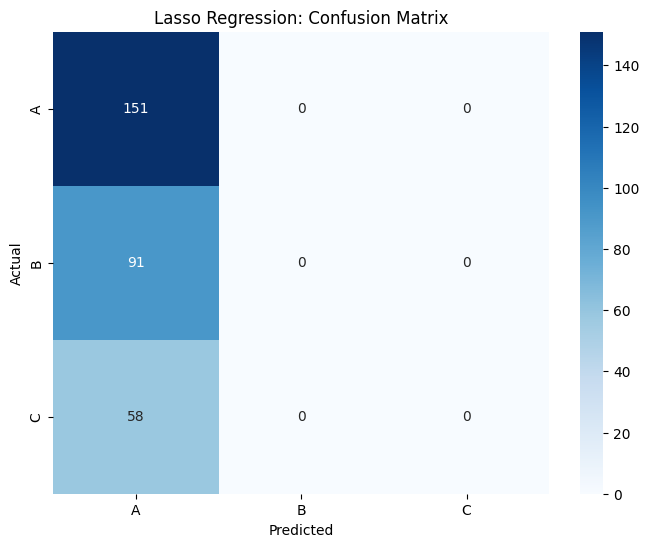


Classification Report:
              precision    recall  f1-score   support

           A       0.50      1.00      0.67       151
           B       0.00      0.00      0.00        91
           C       0.00      0.00      0.00        58

    accuracy                           0.50       300
   macro avg       0.17      0.33      0.22       300
weighted avg       0.25      0.50      0.34       300



In [18]:
# Make predictions on the test data
y_pred_lasso = lasso_final.predict(X_test)
y_pred_proba_lasso = lasso_final.predict_proba(X_test)
# Calculate metrics
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
log_loss_lasso = log_loss(y_test, y_pred_proba_lasso)
print(f"Lasso Regression Results:")
print(f"Accuracy: {accuracy_lasso:.4f}")
print(f"Error Rate: {1 - accuracy_lasso:.4f}")
print(f"Log Loss: {log_loss_lasso:.4f}")
# Confusion matrix
cm_lasso = confusion_matrix(y_test, y_pred_lasso)
print(f"\nConfusion Matrix:")
print(cm_lasso)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lasso, annot=True, fmt='d', cmap='Blues',
            xticklabels=lasso_final.classes_,
            yticklabels=lasso_final.classes_)
plt.title('Lasso Regression: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lasso))

### Elastic Net Regression

#### Cross-validation for the best parameters

/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/s

Best parameters for Elastic Net: {'C': np.float64(0.000774263682681127), 'l1_ratio': np.float64(0.2)}
Best cross-validation score: 1.0268


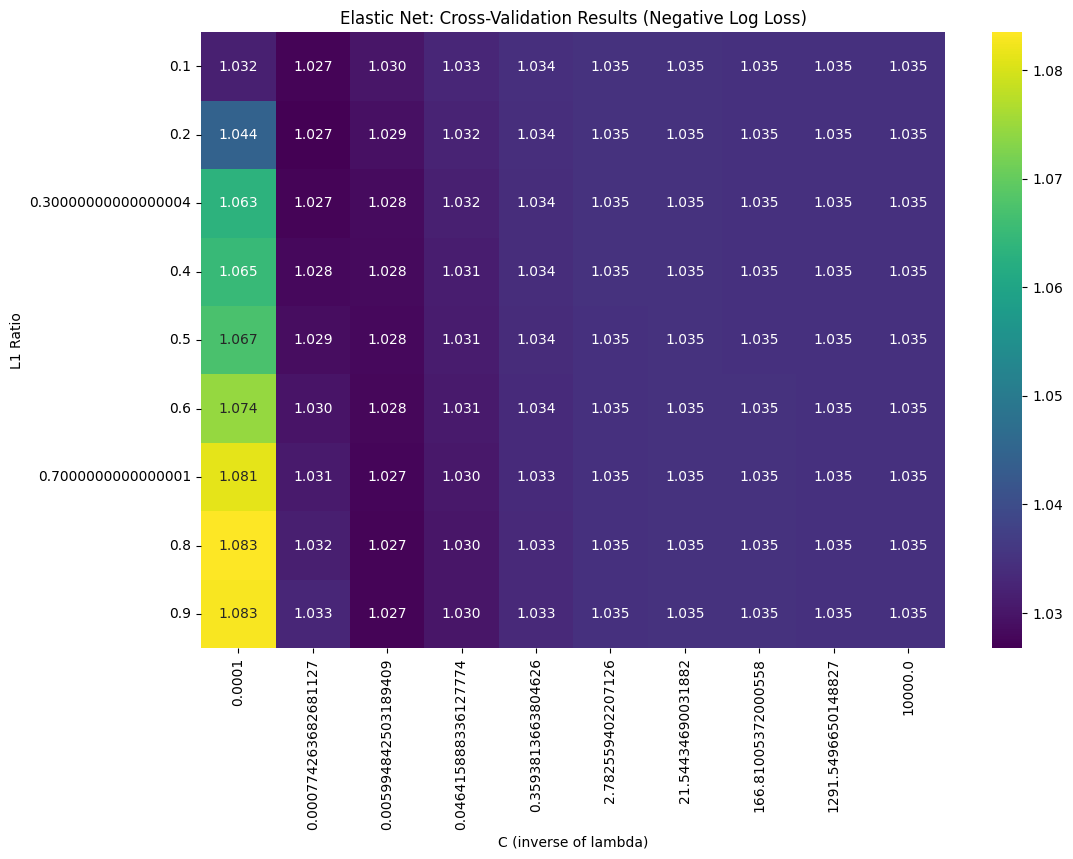

In [19]:
# Define parameter grid for Elastic Net regression
param_grid_elastic = {
    'C': np.logspace(-4, 4, 10),
    'l1_ratio': np.arange(0.1, 1.0, 0.1) # Mixing parameter between L1 and L2
}
# Create Elastic Net logistic regression model
# Note: For Elastic Net with multinomial, we need to use solver='saga'
elastic_model = LogisticRegression(
    penalty='elasticnet', # Elastic Net regularization
    multi_class='multinomial',
    solver='saga', # Solver that supports elasticnet penalty with multinomial
    max_iter=1000,
    random_state=42
)
# Perform grid search with cross-validation
elastic_grid = GridSearchCV(
    elastic_model,
    param_grid_elastic,
    cv=cv,
    scoring='neg_log_loss',
    n_jobs=-1
)
# Fit the grid search
elastic_grid.fit(X_train, y_train)
# Best parameters
print(f"Best parameters for Elastic Net: {elastic_grid.best_params_}")
print(f"Best cross-validation score: {-elastic_grid.best_score_:.4f}")
# Create a heatmap of results
results_elastic = pd.DataFrame(elastic_grid.cv_results_)
results_pivot = results_elastic.pivot_table(
    index='param_l1_ratio',
    columns='param_C',
    values='mean_test_score'
)
plt.figure(figsize=(12, 8))
sns.heatmap(-results_pivot, annot=True, fmt='.3f', cmap='viridis')
plt.title('Elastic Net: Cross-Validation Results (Negative Log Loss)')
plt.xlabel('C (inverse of lambda)')
plt.ylabel('L1 Ratio')
plt.show()

#### Fit Elastic Net Regression

Elastic Net Regression Coefficients:
   age  household  position_level  absent  gender_Male
A  0.0        0.0             0.0     0.0          0.0
B  0.0        0.0             0.0     0.0          0.0
C  0.0        0.0             0.0     0.0          0.0

Non-zero coefficients: 0 out of 15
Sparsity: 100.00%


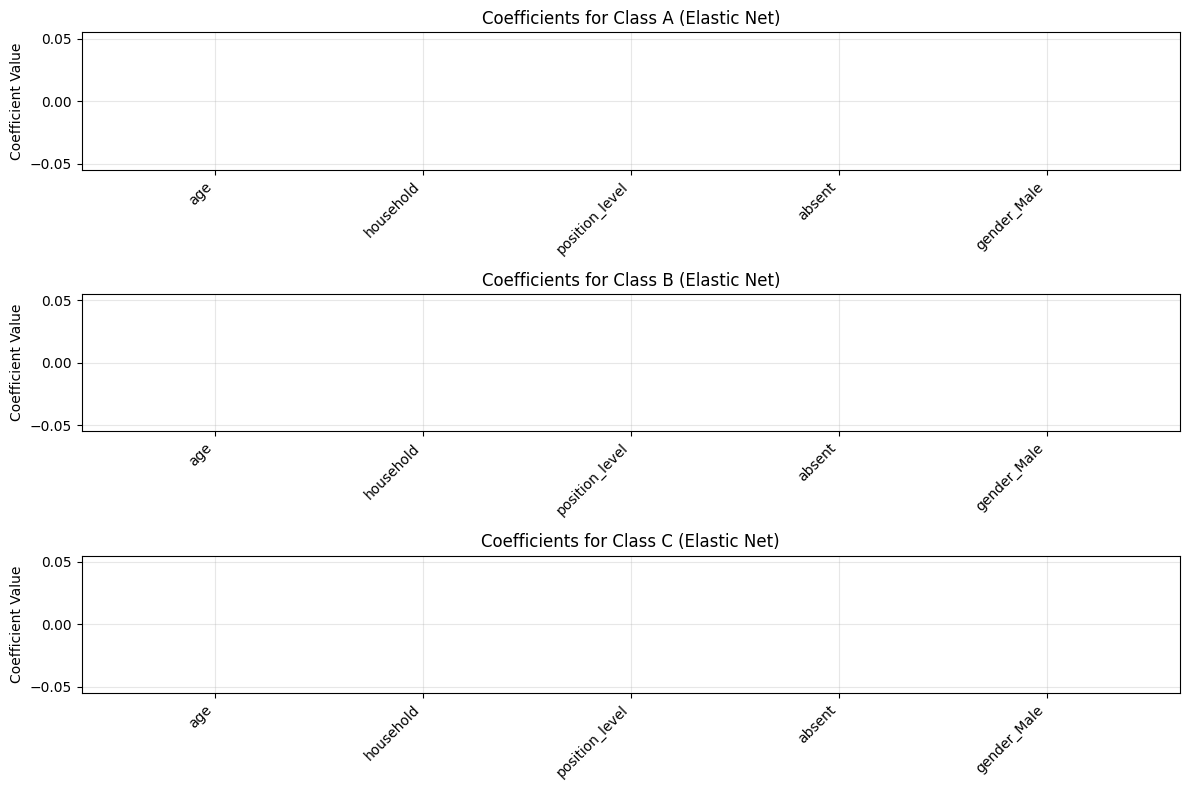

In [20]:
# Fit the final Elastic Net model with the best parameters
best_C_elastic = elastic_grid.best_params_['C']
best_l1_ratio = elastic_grid.best_params_['l1_ratio']
elastic_final = LogisticRegression(
    penalty='elasticnet',
    C=best_C_elastic,
    l1_ratio=best_l1_ratio,
    multi_class='multinomial',
    solver='saga',
    max_iter=1000,
    random_state=42
)
elastic_final.fit(X_train, y_train)
# Display regression coefficients
coef_df_elastic = pd.DataFrame(
    elastic_final.coef_,
    columns=X.columns,
    index=elastic_final.classes_
)
print("Elastic Net Regression Coefficients:")
print(coef_df_elastic.round(4))
# Count non-zero coefficients
non_zero_coeffs_elastic = np.sum(elastic_final.coef_ != 0)
total_coeffs_elastic = elastic_final.coef_.size
print(f"\nNon-zero coefficients: {non_zero_coeffs_elastic} out of {total_coeffs_elastic}")
print(f"Sparsity: {1 - non_zero_coeffs_elastic/total_coeffs_elastic:.2%}")
# Plot coefficients
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(elastic_final.classes_):
    plt.subplot(len(elastic_final.classes_), 1, i+1)
    plt.bar(range(len(X.columns)), elastic_final.coef_[i], alpha=0.7)
    plt.title(f'Coefficients for Class {class_name} (Elastic Net)')
    plt.xticks(range(len(X.columns)), X.columns, rotation=45, ha='right')
    plt.ylabel('Coefficient Value')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Prediction on Test Data

Elastic Net Regression Results:
Accuracy: 0.5033
Error Rate: 0.4967
Log Loss: 1.0253

Confusion Matrix:
[[151   0   0]
 [ 91   0   0]
 [ 58   0   0]]


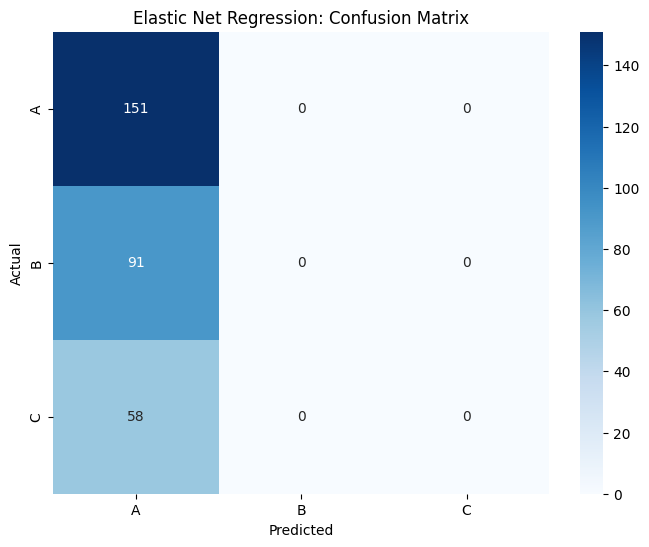


Classification Report:
              precision    recall  f1-score   support

           A       0.50      1.00      0.67       151
           B       0.00      0.00      0.00        91
           C       0.00      0.00      0.00        58

    accuracy                           0.50       300
   macro avg       0.17      0.33      0.22       300
weighted avg       0.25      0.50      0.34       300



In [21]:
# Make predictions on the test data
y_pred_elastic = elastic_final.predict(X_test)
y_pred_proba_elastic = elastic_final.predict_proba(X_test)
# Calculate metrics
accuracy_elastic = accuracy_score(y_test, y_pred_elastic)
log_loss_elastic = log_loss(y_test, y_pred_proba_elastic)
print(f"Elastic Net Regression Results:")
print(f"Accuracy: {accuracy_elastic:.4f}")
print(f"Error Rate: {1 - accuracy_elastic:.4f}")
print(f"Log Loss: {log_loss_elastic:.4f}")
# Confusion matrix
cm_elastic = confusion_matrix(y_test, y_pred_elastic)
print(f"\nConfusion Matrix:")
print(cm_elastic)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_elastic, annot=True, fmt='d', cmap='Blues',
            xticklabels=elastic_final.classes_,
            yticklabels=elastic_final.classes_)
plt.title('Elastic Net Regression: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_elastic))

### Compare All Models

Model Comparison:
         Model  Accuracy  Log Loss  Non-zero Coefficients  Sparsity
0        Ridge    0.5033    1.0260                     15       0.0
1        Lasso    0.5033    1.0252                      0       1.0
2  Elastic Net    0.5033    1.0253                      0       1.0


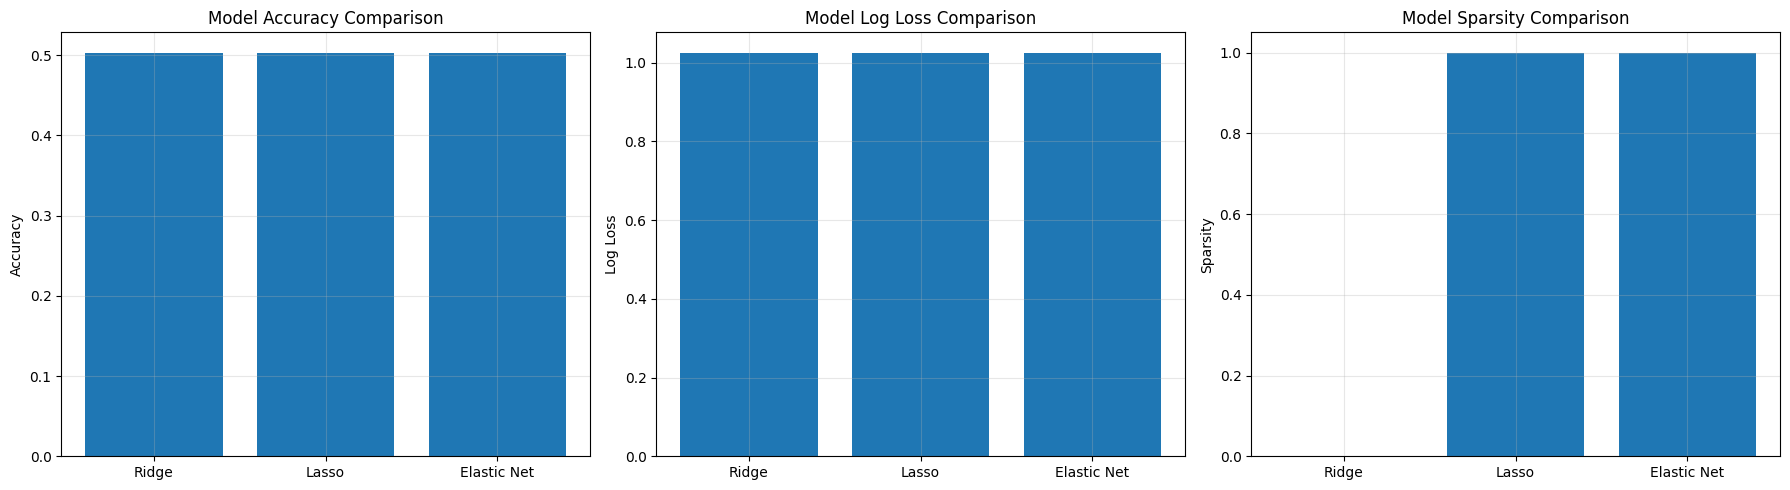

In [22]:
# Compare all three models
models = {
    'Ridge': {'model': ridge_final, 'predictions': y_pred_ridge, 'probabilities': y_pred_proba_ridge},
    'Lasso': {'model': lasso_final, 'predictions': y_pred_lasso, 'probabilities': y_pred_proba_lasso},
    'Elastic Net': {'model': elastic_final, 'predictions': y_pred_elastic, 'probabilities': y_pred_proba_elastic}
}
# Create comparison table
comparison_data = []
for name, model_info in models.items():
    accuracy = accuracy_score(y_test, model_info['predictions'])
    logloss = log_loss(y_test, model_info['probabilities'])
    non_zero = np.sum(model_info['model'].coef_ != 0)
    total = model_info['model'].coef_.size
    sparsity = 1 - non_zero/total
    
    comparison_data.append({
        'Model': name,
        'Accuracy': accuracy,
        'Log Loss': logloss,
        'Non-zero Coefficients': non_zero,
        'Sparsity': sparsity
    })
comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df.round(4))
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True, alpha=0.3)
# Log Loss comparison
axes[1].bar(comparison_df['Model'], comparison_df['Log Loss'])
axes[1].set_title('Model Log Loss Comparison')
axes[1].set_ylabel('Log Loss')
axes[1].grid(True, alpha=0.3)
# Sparsity comparison
axes[2].bar(comparison_df['Model'], comparison_df['Sparsity'])
axes[2].set_title('Model Sparsity Comparison')
axes[2].set_ylabel('Sparsity')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Conclusion

In this tutorial, we explored regularized multinomial logistic regression in Python, focusing on both the manual implementation and using the efficient `scikit-learn` library. We began by understanding the fundamentals of multinomial logistic regression, a model used for predicting categorical outcomes with more than two classes. Recognizing that overfitting can be a significant issue in high-dimensional or small datasets, we introduced regularization techniques, specifically Ridge (L2) and Lasso (L1) regression, which add penalty terms to the model to prevent overfitting and improve generalization.

Key takeaways:

1. **Manual Implementation**: We learned how to implement multinomial logistic regression from scratch using optimization techniques. This approach gives you complete control over the model but requires more code and computational resources.
2. **scikit-learn Implementation**: We used scikit-learn's `LogisticRegression` class, which provides an efficient and well-tested implementation of regularized multinomial logistic regression. This is the recommended approach for most practical applications.
3. **Regularization Types**:
   - Ridge (L2) regularization shrinks coefficients toward zero but rarely sets them exactly to zero.
   - Lasso (L1) regularization can set coefficients exactly to zero, effectively performing feature selection.
   - Elastic Net combines both L1 and L2 penalties, offering a balance between the two approaches.
4. **Hyperparameter Tuning**: We used cross-validation and grid search to find optimal regularization parameters, which is crucial for achieving good model performance.
5. **Model Evaluation**: We evaluated models using multiple metrics including accuracy, log loss, and confusion matrices to get a comprehensive understanding of model performance.

Regularized multinomial logistic regression is a powerful tool for classification problems with multiple classes. By applying regularization, we can build models that generalize better to new data, are more interpretable (especially with Lasso), and can handle high-dimensional datasets effectively.

## Resources

1. [scikit-learn Logistic Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
2. [Multinomial Logistic Regression | Stata Data Analysis Examples](https://stats.oarc.ucla.edu/stata/dae/multinomiallogistic-regression/)
3. [Multinomial Logistic Regression](https://www.sciencedirect.com/topics/mathematics/multinomial-logistic-regression)
4. [Scipy Optimization Documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html)